# **Heart Attack Risk Prediction Project**
### **Author**: Saubhagya Srivastav
### **Date**: 22 FEB 2025


## DATA LOADING

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("/content/framingham_heart_study.csv", header = 0,na_values=["NA"])
df.head()

,male,age,currentSmoker,cigsPerDay,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,RISK
0,1,39,0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### DATA WRANGLING

In [ ]:
df.rename(columns={'prevalentHyp': 'Hypertension'}, inplace=True)
df.replace(np.nan,df.mean(),inplace=True)

In [ ]:
print(df.isnull().sum())

male               0
age                0
currentSmoker      0
cigsPerDay         0
prevalentStroke    0
Hypertension       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
RISK               0
dtype: int64


In [ ]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['age', 'sysBP', 'diaBP', 'totChol', 'glucose', 'BMI']] = scaler.fit_transform(df[['age', 'sysBP', 'diaBP', 'totChol', 'glucose', 'BMI']])


## EXPLORATORY DATA ANALYSIS

In [ ]:
correlations = df.corr()["RISK"].sort_values(ascending=False)
print(correlations)


RISK               1.000000
age                0.225408
sysBP              0.216374
Hypertension       0.177458
diaBP              0.145112
glucose            0.120451
diabetes           0.097344
male               0.088374
totChol            0.081807
BMI                0.074788
prevalentStroke    0.061823
cigsPerDay         0.057646
heartRate          0.022892
currentSmoker      0.019448
Name: RISK, dtype: float64


In [ ]:
print(df.columns)

Index(['male', 'age', 'currentSmoker', 'cigsPerDay', 'prevalentStroke',
       'Hypertension', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI',
       'heartRate', 'glucose', 'RISK'],
      dtype='object')


In [ ]:
df.drop(columns=['currentSmoker', 'heartRate', 'cigsPerDay', 'prevalentStroke'], inplace=True)
df.head()

,male,age,Hypertension,diabetes,totChol,sysBP,diaBP,BMI,glucose,RISK
0,1,0.184211,0,0,0.149406,0.106383,0.232804,0.277024,0.104520,0
1,0,0.368421,0,0,0.242784,0.177305,0.349206,0.319680,0.101695,0
2,1,0.421053,0,0,0.234295,0.208038,0.338624,0.237518,0.084746,0
3,0,0.763158,1,0,0.200340,0.314421,0.497354,0.316045,0.177966,1
4,0,0.368421,0,0,0.302207,0.219858,0.380952,0.183228,0.127119,0


In [ ]:
print(df.describe())


              male          age  Hypertension     diabetes      totChol  \
count  4240.000000  4240.000000   4240.000000  4240.000000  4240.000000   
mean      0.429245     0.462637      0.310613     0.025708     0.220203   
std       0.495027     0.225604      0.462799     0.158280     0.075259   
min       0.000000     0.000000      0.000000     0.000000     0.000000   
25%       0.000000     0.263158      0.000000     0.000000     0.168081   
50%       0.000000     0.447368      0.000000     0.000000     0.215620   
75%       1.000000     0.631579      1.000000     0.000000     0.263158   
max       1.000000     1.000000      1.000000     1.000000     1.000000   

             sysBP        diaBP          BMI      glucose         RISK  
count  4240.000000  4240.000000  4240.000000  4240.000000  4240.000000  
mean      0.230991     0.369288     0.248686     0.118541     0.151887  
std       0.104176     0.126036     0.098659     0.064496     0.358953  
min       0.000000     0.000000 

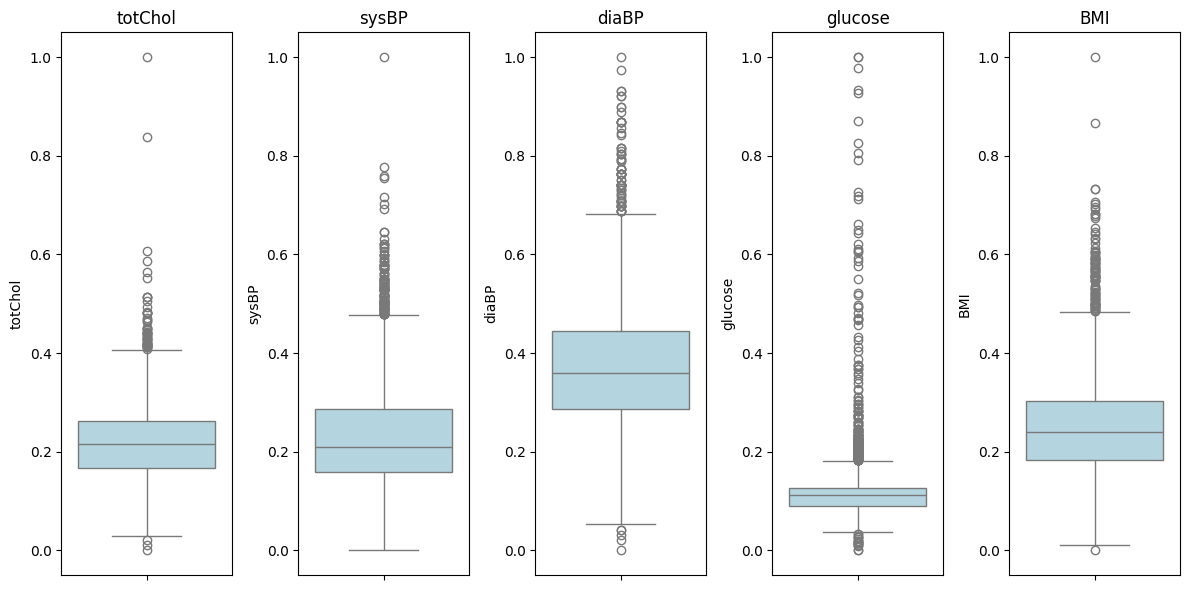

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define numerical columns to check for outliers
num_cols = ['totChol', 'sysBP', 'diaBP', 'glucose', 'BMI']

# Set figure size
plt.figure(figsize=(12, 6))

# Create a boxplot for each numerical feature
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)  # Subplots in a row
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(col)

plt.tight_layout()
plt.show()


***Removing extreme outliers***

In [ ]:
# Detect and remove extreme outliers using Interquartile Range (IQR)
import numpy as np

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Keep values within 1.5 * IQR range
df_filtered = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Check new data size after outlier removal
print("Data size after outlier removal:", df_filtered.shape)


Data size after outlier removal: (1503, 10)


*Lets check for the data balance*

In [ ]:
df['RISK'].value_counts()

,count
RISK,
0,3596
1,644


*AS YOU CAN SEE ABOVE THE DATA IS HIGHLY IMBALANCED*

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Define undersampling strategy (reduce majority class)
undersample = RandomUnderSampler(sampling_strategy=0.6, random_state=1)

# Apply undersampling
X_resampled, y_resampled = undersample.fit_resample(df.drop(columns=['RISK']), df['RISK'])
df_balanced = pd.DataFrame(X_resampled, columns=df.drop(columns=['RISK']).columns)
df_balanced['RISK'] = y_resampled

# Check new class distribution
print(df_balanced['RISK'].value_counts())


RISK
0    1073
1     644
Name: count, dtype: int64


In [ ]:
df=df_balanced
df['RISK'].value_counts()


,count
RISK,
0,1073
1,644


In [ ]:
correlations = df.corr()["RISK"].sort_values(ascending=False)
print(correlations)

RISK            1.000000
age             0.299821
sysBP           0.257330
Hypertension    0.220395
diaBP           0.170527
glucose         0.140112
male            0.132010
diabetes        0.128650
totChol         0.123200
BMI             0.095203
Name: RISK, dtype: float64


## MODEL DEVELOPMENT AND EVALUATION

In [ ]:
from sklearn.model_selection import train_test_split
Y = df['RISK']
X =df.drop('RISK',axis=1)
x_train, x_test, y_train, y_test =train_test_split(X,Y, test_size=0.2,random_state=1)

In [ ]:
#SVM MODEL
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


# Train SVM model
svm_model = SVC(C=1, kernel='rbf', gamma='scale', random_state=1)
svm_model.fit(x_train, y_train)

# Predictions
y_pred = svm_model.predict(x_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6802325581395349
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       212
           1       0.64      0.37      0.47       132

    accuracy                           0.68       344
   macro avg       0.67      0.62      0.62       344
weighted avg       0.67      0.68      0.66       344



In [ ]:
#DECISION TREE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Define Decision Tree model with default parameters
dt = DecisionTreeClassifier(random_state=1)

# Train the model
dt.fit(x_train, y_train)

# Make predictions
y_pred = dt.predict(x_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5959302325581395
              precision    recall  f1-score   support

           0       0.66      0.71      0.68       212
           1       0.47      0.42      0.44       132

    accuracy                           0.60       344
   macro avg       0.57      0.56      0.56       344
weighted avg       0.59      0.60      0.59       344



In [ ]:
#LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(x_train, y_train)

# Predictions
y_pred = log_reg.predict(x_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(report)


Accuracy: 0.6686
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       212
           1       0.62      0.36      0.45       132

    accuracy                           0.67       344
   macro avg       0.65      0.61      0.61       344
weighted avg       0.66      0.67      0.64       344



In [ ]:
#XGBOOST CLASSIFIER
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np




# Train XGBoost with Adjusted Class Weights
xgb = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=200,
    subsample=1.0,
      # Increased weight
    random_state=42
)

xgb.fit(x_train, y_train)

# Predictions
y_pred = xgb.predict(x_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6424418604651163
              precision    recall  f1-score   support

           0       0.67      0.84      0.74       212
           1       0.56      0.32      0.41       132

    accuracy                           0.64       344
   macro avg       0.61      0.58      0.58       344
weighted avg       0.62      0.64      0.61       344



In [ ]:
#RANDOM TREE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report



# Define Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=3, random_state=1)
rf.fit(x_train, y_train)

# Predict
y_pred_rf = rf.predict(x_test)

# Evaluate model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.6395348837209303
              precision    recall  f1-score   support

           0       0.67      0.82      0.74       212
           1       0.55      0.35      0.43       132

    accuracy                           0.64       344
   macro avg       0.61      0.58      0.58       344
weighted avg       0.62      0.64      0.62       344



***FINDING THE BEST MODEL***

In [ ]:

results = {
    "Logistic Regression": {"Accuracy": 0.6628, "F1 Score": 0.64},
    "Decision Tree": {"Accuracy": 0.5988372093023255, "F1 Score": 0.59},
    "Random Forest": {"Accuracy": 0.6395348837209303, "F1 Score": 0.62},
    "SVM": {"Accuracy": 0.68, "F1 Score": 0.66},
    "XGBoost": {"Accuracy": 0.6424418604651163, "F1 Score": 0.61}
}

# Select the best model based on F1 Score
best_model = max(results, key=lambda x: results[x]['F1 Score'])

# Print results
for model, scores in results.items():
    print(f"{model}: Accuracy = {scores['Accuracy']:.4f}, F1 Score = {scores['F1 Score']:.4f}")

print(f"\n✅ Best Model: {best_model} with F1 Score = {results[best_model]['F1 Score']:.4f}")


Logistic Regression: Accuracy = 0.6628, F1 Score = 0.6400
Decision Tree: Accuracy = 0.5988, F1 Score = 0.5900
Random Forest: Accuracy = 0.6395, F1 Score = 0.6200
SVM: Accuracy = 0.6800, F1 Score = 0.6600
XGBoost: Accuracy = 0.6424, F1 Score = 0.6100

✅ Best Model: SVM with F1 Score = 0.6600


In [ ]:
import joblib

# Save the new model
joblib.dump(svm_model, "new_model.pkl")




['new_model.pkl']

In [ ]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [ ]:
from google.colab import files
files.download("scaler.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>